### Library Import

In [89]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials

from LSMPricing import lsm_pricer
from BinomialTreePricing import btree_pricer
from BSAnalyticalPricing import BSAnalytical
from MonteCarlo import simulate_gbm_paths

### AAPL Option Chain Data Import

In [5]:
currentdir = os.getcwd()
targetdir = currentdir + "\\aapl_eod_2019-ubqxfb"
files = os.listdir(targetdir)

data = pd.read_csv(targetdir + "\\"+files[0], sep=",", low_memory=False)
for i in range(1, len(files)):
    data = pd.concat([data, pd.read_csv(targetdir + "\\"+files[i], sep=",", low_memory=False)])
data.reset_index(inplace=True)

In [50]:
data.columns

Index(['index', '[QUOTE_UNIXTIME]', ' [QUOTE_READTIME]', ' [QUOTE_DATE]',
       ' [QUOTE_TIME_HOURS]', ' [UNDERLYING_LAST]', ' [EXPIRE_DATE]',
       ' [EXPIRE_UNIX]', ' [DTE]', ' [C_DELTA]', ' [C_GAMMA]', ' [C_VEGA]',
       ' [C_THETA]', ' [C_RHO]', ' [C_IV]', ' [C_VOLUME]', ' [C_LAST]',
       ' [C_SIZE]', ' [C_BID]', ' [C_ASK]', ' [STRIKE]', ' [P_BID]',
       ' [P_ASK]', ' [P_SIZE]', ' [P_LAST]', ' [P_DELTA]', ' [P_GAMMA]',
       ' [P_VEGA]', ' [P_THETA]', ' [P_RHO]', ' [P_IV]', ' [P_VOLUME]',
       ' [STRIKE_DISTANCE]', ' [STRIKE_DISTANCE_PCT]'],
      dtype='object')

In [72]:
first_day_options = data[data[" [QUOTE_DATE]"] == " 2019-01-02"]
first_day_1y_options = first_day_options[first_day_options[" [EXPIRE_DATE]"] == ' 2020-01-17']
# display(first_day_1y_options.head())
# first_day_1y_options[" [STRIKE]"]

### Get AAPL Stock Data

In [63]:
start_date="2019-01-01"
end_date="2020-01-01"
time_interval="daily"

aapl = YahooFinancials("AAPL")
aapl = aapl.get_historical_price_data(start_date=start_date, end_date=end_date, time_interval=time_interval)
aapl = pd.DataFrame(aapl["AAPL"]['prices'])
aapl = aapl.drop('date', axis=1).set_index('formatted_date')

### Set Params

In [69]:
sig = np.std(aapl["adjclose"].pct_change()[1:])*np.sqrt(len(aapl))
nsims = 10000
S0 = 157.92
T = 1
discrete_freq = 252
OP_TYPE = "put"
K = 155.0
r = .06
POLY_DEGREE = 5

In [86]:
actual_data_op = first_day_1y_options[first_day_1y_options[" [STRIKE]"] == K]
actual_call = (float(actual_data_op[' [C_BID]']) + float(actual_data_op[' [C_ASK]']))/2
actual_put = (float(actual_data_op[' [P_BID]']) + float(actual_data_op[' [P_ASK]']))/2
print("Actual American Put: ", actual_put)
print("Actual American call: ", actual_call)

Actual American Put:  16.93
Actual American call:  21.405


### Pricing American Options (AAPL) using LSM Monte Carlo

In [87]:
put_price = lsm_pricer("ap", nsims, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
call_price = lsm_pricer("ac", nsims, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
print("LSM MC American Put: ", put_price)
print("LSM MC American call: ", call_price)

LSM MC American Put:  10.776260895351635
LSM MC American call:  21.487498071751144


### Pricing American Options (AAPL) using BT

In [88]:
# Without control variates
put_price = btree_pricer(S0, K, sig, r, T, 1000, "ap")
call_price = btree_pricer(S0, K, sig, r, T, 1000, "ac")
print("BT American Put: ", put_price)
print("BT American call: ", call_price)

BT American Put:  11.395852199010301
BT American call:  22.477613462417732


# Charts

##### Error vs Num. Simulations Graph (MC)

In [93]:
call_fnsims = []
for i in range(1000, 100000, 4000):
    # put_price = lsm_pricer("ap", i, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
    call_price = lsm_pricer("ac", i, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
    call_fnsims.append(call_price)

In [103]:
put_fnsims = []
for i in range(1000, 100000, 4000):
    put_price = lsm_pricer("ap", i, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
    # put_price = lsm_pricer("ac", i, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
    put_fnsims.append(put_price)

Text(0.5, 1.0, 'Error vs Num. Simulations (1k to 100k) - LSM Call')

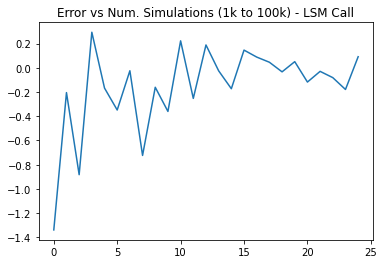

In [95]:
plt.plot(actual_call - np.array(call_fnsims))
plt.title("Error vs Num. Simulations (1k to 100k) - LSM Call")

Text(0.5, 1.0, 'Error vs Num. Simulations (1k to 100k) - LSM Put')

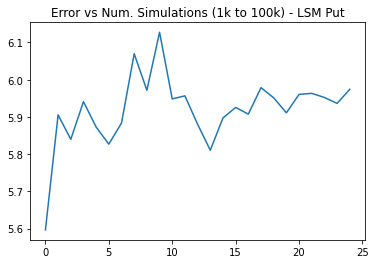

In [104]:
plt.plot(actual_put - np.array(put_fnsims))
plt.title("Error vs Num. Simulations (1k to 100k) - LSM Put")

##### Error vs Num. Trees Graph (MC)

In [101]:
call_fntree = []
for i in range(3, 1000, 10):
    # put_price = lsm_pricer("ap", i, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
    call_price = btree_pricer(S0, K, sig, r, T, i, "ac")
    call_fntree.append(call_price)

In [105]:
put_fntree = []
for i in range(3, 1000, 10):
    # put_price = lsm_pricer("ap", i, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
    put_price = btree_pricer(S0, K, sig, r, T, i, "ap")
    put_fntree.append(put_price)

Text(0.5, 1.0, 'Error vs Num. Steps (3 to 1000) - BT Call')

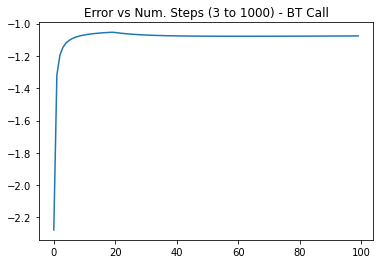

In [102]:
plt.plot(actual_call - np.array(call_fntree))
plt.title("Error vs Num. Steps (3 to 1000) - BT Call")

Text(0.5, 1.0, 'Error vs Num. Steps (3 to 1000) - BT Put')

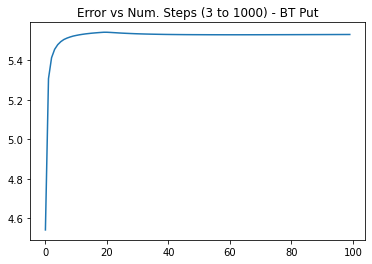

In [106]:
plt.plot(actual_put - np.array(put_fntree))
plt.title("Error vs Num. Steps (3 to 1000) - BT Put")